In [1]:
import sys
sys.path.append("../")

In [2]:
import alphatsp
import alphatsp.tsp
import alphatsp.util
import alphatsp.solvers.exact
import alphatsp.solvers.gurobi
import alphatsp.solvers.heuristics
import alphatsp.solvers.mcts

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

In [4]:
import torch_geometric
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

In [5]:
import tqdm

In [6]:
import numpy as np
import random
import copy
import math
import queue

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [9]:
class PolicyNetwork(nn.Module):
    def __init__(self, d=2):
        super(PolicyNetwork, self).__init__()
        self.conv1 = GCNConv(d,  16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 1)
        self.fc    = nn.Linear(16, 1)
    
    def forward(self, graph):
        x, edges, choices = graph.pos, graph.edge_index, graph.y
        
        x = self.conv1(x, edges)
        x = F.relu(x)
        x = self.conv2(x, edges)
        x = F.relu(x)
        
        c = self.conv3(x, edges)
        choice = torch.masked_select(c.squeeze(), choices)
        choice = F.softmax(choice, dim=0)
        
        v = global_mean_pool(x, torch.zeros(graph.num_nodes, dtype=torch.long))
        value = self.fc(v)

        return choice, value
    
policy_network = PolicyNetwork()
optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [133]:
class MCTSNode:

    def __init__(self, p=None, t=[0], r=None, tsp=None):
        self.parent = p
        self.tsp = tsp
        self.tour = t
        self.remaining = r if r is not None else list(range(1, tsp.n))
        self.visits = 0
        self.total_score = 0
        self.avg_score = 1 / (len(self.remaining)+1)
        self.c = 0.7
        self.n = tsp.n
        self.children = []
        self.graph = None
        self.action = self.tour[-1]

    def expand(self):
        k = random.choice(self.remaining)
        t = copy.copy(self.tour)
        r = copy.copy(self.remaining)
        t.append(k)
        r.remove(k)
        child = MCTSNode(self, t, r, self.tsp)
        self.children.append(child)
        return child
    
    def add_child(self, k):
        for child in self.children:
            if child.action == k:
                return child
        t = copy.copy(self.tour)
        r = copy.copy(self.remaining)
        t.append(k)
        r.remove(k)
        child = MCTSNode(self, t, r, self.tsp)
        self.children.append(child)
        return child

    def backprop(self, reward):
        self.visits += 1
        self.total_score += reward
        self.avg_score = self.total_score / self.visits
        if self.parent is not None:
            self.parent.backprop(reward)

    def simulate(self):
        random.shuffle(self.remaining)
        t = self.tour + self.remaining + [0]
        return self.tsp.payoff(t)

    def has_children(self):
        return len(self.children) != 0

    def is_leaf(self):
        return len(self.tour) == self.n
    
    def is_fully_expanded(self):
        return len(self.remaining) == len(self.children)

    def get_tour(self):
        return self.tour + [self.tour[0]]

    def best_child_score(self):
        return max(self.children, key = lambda child: child.avg_score)

    def best_child_uct(self):
        k = math.log(self.visits)
        return max(self.children, key = lambda child: child.avg_score + self.c * math.sqrt(2 * k / child.visits))

    def best_child_visits(self):
        return max(self.children, key = lambda child: child.visits)
    
    def best_child_policy(self, model):
        if len(self.children) == 0: raise Exception("No children to select from.")
        if len(self.children) == 1: return self.children[0]
        
        actions = [child.action for child in self.children]
        r = list(set.intersection(set(actions), set(self.remaining)))
        z = np.zeros(self.n, dtype=np.int)
        z[r] = 1
        z = z[self.remaining]
        
        graph = self.construct_graph()
        pred, value = model(graph)
         
        pred = pred.squeeze()[z]
        selection = torch.argmax(pred)
        
        return self.children[selection]
    
    def select_child_policy(self, model):
        if len(self.children) == 0: raise Exception("No children to select from.")
        if len(self.children) == 1: return self.children[0]
        graph = self.construct_graph()
        pred, value = model(graph)
        selection = torch.multinomial(pred.squeeze(), 1)
        return self.children[selection]
    
    def best_remaining_policy(self, model):
        if len(self.remaining) == 0: raise Exception("No remaining to select from.")
        if len(self.remaining) == 1: return self.add_child(self.remaining[0])
        
        graph = self.construct_graph()
        pred, value = model(graph)
        
        selection = torch.argmax(pred.squeeze()).item()
        selection = self.remaining[selection]
        
        return self.add_child(selection)
    
    def select_remaining_policy(self, model):
        if len(self.remaining) == 0: raise Exception("No remaining to select from.")
        if len(self.remaining) == 1: return self.add_child(self.remaining[0])
        
        graph = self.construct_graph()
        pred, value = model(graph)
        
        selection = torch.argmax(pred.squeeze()).item()
        selection = self.remaining[selection]
        
        selection = torch.multinomial(pred.squeeze(), 1)
        return self.add_child(selection)
    
    def construct_graph(self):
        if self.graph is not None:
            return self.graph

        points = torch.tensor(self.tsp.points).to(dtype=torch.float)

        edges = torch.zeros((2, len(self.tour)-1), dtype=torch.long)
        for i in range(len(self.tour)-1):
            edges[0, i] = self.tour[i]
            edges[1, i] = self.tour[i+1]

        choices = torch.zeros(self.n, dtype=torch.uint8)
        choices[self.remaining] = 1
        
        x = torch.cat([points, choices.unsqueeze(-1).to(dtype=torch.float)], dim=-1)

        self.graph = Data(x=x, pos=points, edge_index=edges, y=choices)
        
        return self.graph

In [11]:
class MCTSSolver:
    
    def __init__(self, tsp, iterations=1000):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.iterations = iterations
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.best_child_uct()
        return node

In [93]:
class PolicySolver:
    
    def __init__(self, tsp, model):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.model = model
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = node.best_remaining_policy(model=self.model)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

In [64]:
class PolicyMCTSSolver:
    
    def __init__(self, tsp, model, iterations=50):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.iterations = iterations
        self.model = model
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.select_child_policy(self.model)
        return node

In [65]:
class MCTSTrainer:
    
    def __init__(self, tsp, model, example_queue, iterations=1000):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.iterations = iterations
        self.example_queue = example_queue
        self.model = model
        self.losses = []
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
            self.generate_example(node.parent)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.best_child_uct()
        return node
    
    def generate_example(self, node):
        
        # construct graph
        graph = node.construct_graph()
        
        # construct labels
        
        choice_probs = [(child.tour[-1], child.visits) for child in node.children]
        choice_probs = sorted(choice_probs, key = lambda c: c[1])
        choice_probs = [c[0] for c in choice_probs]
        choice_probs = torch.tensor(choice_probs).to(dtype=torch.float)
        choice_probs = choice_probs / choice_probs.sum()
        
        choice = torch.argmax(choice_probs)
        
        pred_value = torch.tensor(node.avg_score)
        
        # add to queue
        example = {
            "graph": graph,
            "choice_probs": choice_probs,
            "choice": choice,
            "pred_value": pred_value,
        }
        self.example_queue.put(example)
        
    def train_example(self):
        self.model.train()
        
        example = self.example_queue.get()
        graph, choice_probs, value = example["graph"], example["choice_probs"], example["pred_value"]
        
        pred_choices, pred_value = self.model(graph)
        loss = loss_fn(pred_choices, choice_probs) + (0.2 * loss_fn(pred_value, value))
        
        self.losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    def train(self):
        model.train()
        while not self.example_queue.empty():

            example = self.example_queue.get()
            graph, choice_probs, value = example["graph"], example["choice_probs"], example["pred_value"]
            
            pred_choices, pred_value = self.model(graph)
            loss = loss_fn(pred_choices, choice_probs) + (0.2 * loss_fn(pred_value, value))
            
            self.losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [54]:
train_queue = queue.Queue()

In [55]:
tsp = alphatsp.tsp.TSP(10, 2)
solver = MCTSSolver(tsp)
node = solver.solve()

In [27]:
for _ in range(5):
    tsp = alphatsp.tsp.TSP(10, 2)
    solver = MCTSTrainer(tsp, train_queue)
    solver.solve()
while not train_queue.empty():
    print(train_queue.get())

{'graph': Data(edge_index=[2, 0], pos=[10, 2], y=[10]), 'choice_probs': tensor([0.1389, 0.1944, 0.0278, 0.0833, 0.0833, 0.2222, 0.0278, 0.1667, 0.0556]), 'choice': tensor(5), 'pred_value': tensor(0.8006)}
{'graph': Data(edge_index=[2, 1], pos=[10, 2], y=[10]), 'choice_probs': tensor([0.0811, 0.1081, 0.0270, 0.0270, 0.1892, 0.2432, 0.1622, 0.1622]), 'choice': tensor(5), 'pred_value': tensor(0.8151)}
{'graph': Data(edge_index=[2, 2], pos=[10, 2], y=[10]), 'choice_probs': tensor([0.0263, 0.0789, 0.0789, 0.2368, 0.1053, 0.2368, 0.2368]), 'choice': tensor(6), 'pred_value': tensor(0.8225)}
{'graph': Data(edge_index=[2, 3], pos=[10, 2], y=[10]), 'choice_probs': tensor([0.0476, 0.3333, 0.0476, 0.1905, 0.1905, 0.1905]), 'choice': tensor(1), 'pred_value': tensor(0.8305)}
{'graph': Data(edge_index=[2, 4], pos=[10, 2], y=[10]), 'choice_probs': tensor([0.0500, 0.4000, 0.2500, 0.1500, 0.1500]), 'choice': tensor(1), 'pred_value': tensor(0.8431)}
{'graph': Data(edge_index=[2, 5], pos=[10, 2], y=[10]),

In [33]:
for _ in range(700):
    tsp = alphatsp.tsp.TSP(20, 2)
    solver = MCTSTrainer(tsp, train_queue)
    solver.solve()

In [36]:
def train(model):
    losses = []
    model.train()
    while not train_queue.empty():
        example = train_queue.get()
        graph, choice_probs, value = example["graph"], example["choice_probs"], example["pred_value"]
        pred_choices, pred_value = model(graph)
        loss = loss_fn(pred_choices, choice_probs) + (0.2 * loss_fn(pred_value, value))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, losses

In [37]:
policy_network, losses = train(policy_network)

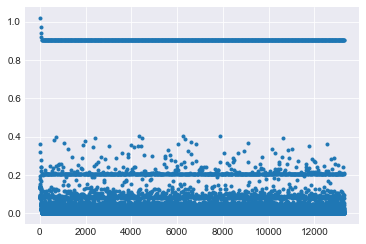

In [45]:
plt.scatter(x=np.arange(len(losses)), y=losses, marker='.')
plt.show()

In [138]:
for _ in range(5):
    tsp = alphatsp.tsp.TSP(20, 2)
    solver = PolicySolver(tsp, policy_network)
    print(solver.solve())

([0, 8, 9, 1, 19, 15, 3, 14, 18, 13, 10, 2, 16, 12, 17, 7, 5, 4, 11, 6, 0], 11.90254787457621)
([0, 1, 14, 3, 9, 12, 5, 10, 7, 8, 6, 4, 2, 16, 17, 18, 15, 13, 19, 11, 0], 10.1130635197178)
([0, 5, 17, 6, 8, 19, 1, 12, 16, 13, 3, 9, 4, 15, 2, 10, 11, 18, 14, 7, 0], 7.706859995211765)
([0, 18, 4, 9, 16, 2, 10, 11, 1, 7, 8, 13, 12, 3, 14, 15, 17, 19, 5, 6, 0], 5.61296216397995)
([0, 15, 13, 8, 9, 5, 16, 18, 10, 19, 17, 11, 12, 7, 1, 4, 3, 6, 14, 2, 0], 7.370909506623001)


In [48]:
# torch.save(policy_network.state_dict(), "policy_network_01.pth")